#SkipGram Model

El modelo SkipGram es una red neuronal con una sola capa escondida. El principal objetivo de este modelo es entrenar los pesos de la red, ya que estas representarán los vectores de palabras que estamos tratando de aprender.

Esta red toma un conjunto preferentemente grande de sentencias y se entrena de la siguiente forma:


1.   Recorremos el conjunto de sentencias palabra por palabra. Tomamos una palabra específica de la sentencia y la llamamos palabra central.


*   $\textbf{Las}$ rosas rojas estan floreciendo.
*   Las $\textbf{rosas}$ rojas estan floreciendo.
*   Las rosas $\textbf{rojas}$ estan floreciendo.


2.   Definimos un valor de $\textit{window size}=k$. Para cada palabra central escogemos las palabras aleatoriamente las palabras que están a la derecha e izquierda en $k$ pasos, estas palabras son llamadas palabras de contexto.


>   Por ejemplo, para la palabra $\textbf{rosas}$, si tenemos un $\textit{window size} = 2$
*  $\textbf{Las}$ rosas $\textbf{rojas}$ $\textbf{estan}$ floreciendo.

> Nuestra lista de dados para esta sentencia es:
*   rosas las
*   rosas rojas
*   rosas están

3.   La red neuronal va calcular la probabilidad de cada palabra en nuestro vocabulario sea la palabra de contexto que escogimos teniendo como entrada a la red nuestra palabra central.

De acuerdo a cada par de palabras la red aprende el número de veces que ocurre cada par en la etapa de entrenamiento. Por ejemplo, el par "New York" es mas probable a aparecer que "New Yersey". Entonces cuando el entrenamiento se termina si la palabra de entrada es "New" salida tendrá una probabilidad mas alta para "York" que "Yersey".

##Ejemplo con Pytorch

Primero vamos a crear un corpus pequeño.

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import torch
from torch.optim import SGD
from torch.autograd import Variable, profiler
import numpy as np
import torch.functional as F
import torch.nn.functional as F

In [0]:
corpus = [
    "he is a king",
    "she is a queen",
    "she is a woman",
    "he is a man",
    "warsaw is poland capital",
    "berlin is germany capital",
    "paris is france capital",
]

##Paso 1: Creamos el vocabulario
Nuestro vocabulario es una lista de palabras únicas con su respectivo indice.


In [0]:
def tokenize_corpus(corpus):
  tokens = [x.split() for x in corpus]
  return tokens

tokenized_corpus = tokenize_corpus(corpus)

Generamos una lista de tokens, y creamos dos diccionarios para mapear las palabras y sus indices.

In [40]:
tokenized_corpus

[['he', 'is', 'a', 'king'],
 ['she', 'is', 'a', 'queen'],
 ['she', 'is', 'a', 'woman'],
 ['he', 'is', 'a', 'man'],
 ['warsaw', 'is', 'poland', 'capital'],
 ['berlin', 'is', 'germany', 'capital'],
 ['paris', 'is', 'france', 'capital']]

In [0]:
vocabulary = []
for sentence in tokenized_corpus:
  for token in sentence:
    if token not in vocabulary:
      vocabulary.append(token)
word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}
vocabulary_size = len(vocabulary)

In [42]:
idx2word

{0: 'he',
 1: 'is',
 2: 'a',
 3: 'king',
 4: 'she',
 5: 'queen',
 6: 'woman',
 7: 'man',
 8: 'warsaw',
 9: 'poland',
 10: 'capital',
 11: 'berlin',
 12: 'germany',
 13: 'paris',
 14: 'france'}

## Paso 2: Generamos pares 

Dado un window size (k). Donde el primer elemento es la palabra central y el segundo elemento es la palabra de contexto, es decir la palabra adyacente en k pasos  a la izquierda y derecha de la palabra central.


In [0]:
window_size = 2
idx_pairs = []
for sentence in tokenized_corpus:
  indices = [word2idx[word] for word in sentence]
  for center_word_pos in range(len(indices)):
    for w in range(-window_size, window_size + 1):
      context_word_pos = center_word_pos + w
      if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
        continue
      context_word_idx = indices[context_word_pos]
      idx_pairs.append((indices[center_word_pos], context_word_idx))
  
idx_pairs = np.array(idx_pairs)

In [0]:
pairwords = [idx2word[pair[0]] + " " + idx2word[pair[1]] for pair in idx_pairs]

In [45]:
pairwords

['he is',
 'he a',
 'is he',
 'is a',
 'is king',
 'a he',
 'a is',
 'a king',
 'king is',
 'king a',
 'she is',
 'she a',
 'is she',
 'is a',
 'is queen',
 'a she',
 'a is',
 'a queen',
 'queen is',
 'queen a',
 'she is',
 'she a',
 'is she',
 'is a',
 'is woman',
 'a she',
 'a is',
 'a woman',
 'woman is',
 'woman a',
 'he is',
 'he a',
 'is he',
 'is a',
 'is man',
 'a he',
 'a is',
 'a man',
 'man is',
 'man a',
 'warsaw is',
 'warsaw poland',
 'is warsaw',
 'is poland',
 'is capital',
 'poland warsaw',
 'poland is',
 'poland capital',
 'capital is',
 'capital poland',
 'berlin is',
 'berlin germany',
 'is berlin',
 'is germany',
 'is capital',
 'germany berlin',
 'germany is',
 'germany capital',
 'capital is',
 'capital germany',
 'paris is',
 'paris france',
 'is paris',
 'is france',
 'is capital',
 'france paris',
 'france is',
 'france capital',
 'capital is',
 'capital france']

##Skip-Gram
Predecimos la probabilidad de la palabra contexto dado la palabra central. La distribución de probabilidad para un par es:
$$P(context|center;\theta)$$
Ejemplo:
$$P(king|is)$$
Maximizando todo para todos los pares tenemos:
$$max\prod_{center}\prod_{context}{P(context|center;\theta)}$$

###Paso 1: Reemplazamos la probabilidad con Negative Log Likelihood.
$$\min_{\theta} - log\prod_{center}\prod_{context}P(context|center, \theta)$$
###Paso 2: Reemplazamos los productos con sumas usando $log(a.b) = log{a} + log{b}$ y dividimos por el numero de pares $(T)$:
$$loss = -\frac{1}{T}\sum_{center}\sum_{context}logP(context|center,\theta)$$
##Probabilidad Softmax
Si asumimos que cada palabra es un vector, tenemos el vector de la palabra central $v$ y el vector de la palabra de contexto $u$. 

$$P(context|center) = \frac{exp(u^{T}_{context}v_{center})}{\sum\limits_{w \in \text{vocab}} exp(u_{w}^{T}v_{center})}$$

Para cada palabra central y la palabra contexto candidata en el vocabulario calculamos su similaridad ($u_{context}^Tv_{center}$) y dividimos por la suma de la similaridad de cada palabra del vocabulario con la palabra central.



## Red Neuronal
### Capa de Entrada
Cada palabra central es representada con un vector de entrada llamado $\textit{one-hot}$ de dimension $[1, vocabulary\_size]$, que guarda el valor de $1$ en la posición correspondiente a su indice en el vocabulario y $0$s en el resto de posiciones.

In [0]:
def get_input_layer(word_idx):
  x = torch.zeros(vocabulary_size).float()
  x[word_idx] = 1.0
  return x

##Capa Escondida
Se construye una matriz aleatoria $W1$ de dimensión $[embedding\_dims, vocabulary\_size]$.
No hay una función de activación en la capa escondida. Mas bien de acuerdo a la forma del vector one-hot el producto con esta matriz se convierte en una operacion de lookup. Es decir, si la posicion del valor $1$ en el vector one-hot de la palabra es $i$, se extrae la fila $i$. 


##Capa de Salida
Esta capa debe tener $vocabulary\_size$ neuronas porque se genera una probabilidad de que la palabra escogida aleatoriamente sea una palabra del contexto de la palabra de entrada. Además, $W2$ tiene $[vocabulary\_size, embedding\_dims]$ de dimensión.


In [47]:
embedding_dims = 5
# matriz inicial random d*v
W1 = Variable(torch.randn(embedding_dims, vocabulary_size).float(), requires_grad=True)
W2 = Variable(torch.randn(vocabulary_size, embedding_dims).float(), requires_grad=True)
num_epochs = 100
learning_rate = 0.001
for epo in range(num_epochs):
  loss_val = 0
  for data, target in idx_pairs:
    x = Variable(get_input_layer(data)).float()
    y_true = Variable(torch.from_numpy(np.array([target])).long())
    
    # Capa escondida
    z1 = torch.matmul(W1, x)
    
    # Capa de salida
    z2 = torch.matmul(W2, z1)
    
    log_softmax = F.log_softmax(z2, dim=0)
    
    loss = F.nll_loss(log_softmax.view(1,-1), y_true)
    loss_val += loss.data[0]
    loss.backward()
    W1.data -= learning_rate * W1.grad.data
    W2.data -= learning_rate * W2.grad.data
    
    W1.grad.data.zero_()
    W2.grad.data.zero_()
  if epo % 10 == 0:
    print(f'Loss at epo {epo}: {loss_val/len(idx_pairs)}')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Loss at epo 0: 4.212227821350098
Loss at epo 10: 3.827129364013672
Loss at epo 20: 3.536381959915161
Loss at epo 30: 3.3085684776306152
Loss at epo 40: 3.1279096603393555
Loss at epo 50: 2.983936071395874
Loss at epo 60: 2.8685877323150635
Loss at epo 70: 2.7753350734710693
Loss at epo 80: 2.6989493370056152
Loss at epo 90: 2.6353745460510254


Después del entrenamiento tenemos dos matrices la primera W1 representa el vector $v$ de la palabra central. La matriz W2 representa el vector $u$ de la palabra de contexto.


Para conocer cuán similares son dos palabras. Hallamos el cosine similarity entre los vectores $u$ y $v$.
$$\text{cosine similarity}(u,v) = \frac{u.v}{||u||_2||v||_2}=cos(\theta)$$

Donde ${||u||}_2 = \sqrt{\sum_{i=1}^{n}u_i^2}$.
Si $u$ y $v$ son muy similares, el valor del coseno será cercano a $1$. Si ellos no son similares tendrán un valor pequeño cercano a $0$. Si son similares pero opuestos el valor de coseno será $-1$.

In [50]:
def cosine_similarity(u, v):
    distance = 0.0
    dot = torch.dot(u,v)
    norm_u = torch.sqrt(torch.sum(u**2))
    norm_v = torch.sqrt(torch.sum(v**2))
    cosine_similarity = dot/(norm_u*norm_v)
    return cosine_similarity
  

cosine_similarity(W1[:,word2idx["man"]], W1[:, word2idx["woman"]])

tensor(-0.6108, grad_fn=<DivBackward1>)

Podemos hallar analogias de la siguiente manera:
Si "a" es a "b" como "c" es a .... 
Por ejemplo: "man es a woman as king es a queen." 
Entonces calculamos la equivalencia de las diferencias de vectores:
$$e_b - e_a \approx e_d - e_c$$

In [0]:
def get_analogy(a, b, c, W1):
  a, b, c = a.lower(), b.lower(), c.lower()
  w2v_a, w2v_b, w2v_c = W1[word2idx[a],:], W1[word2idx[b],:], W1[word2idx[c],:]
  max_cosine_sim = -100
  best_word = {}
  words = word2idx.keys()
  for w in words:
    if w in [a, b, c]:
      continue  
    cosine_sim = cosine_similarity(w2v_b - w2v_a, W1[word2idx[w],:] - w2v_c)
    best_word[w] = cosine_sim
  return best_word

In [96]:
get_analogy("berlin", "germany", "paris", W2)

'france'

##Visualización de los vectores de palabras

Para visualizar estos vectores usamos t-distributed stochastic neighbor embedding (t-SNE) una técnica de reducción de dimensionalidad que permite visualizar altas dimensiones de espacio en dimensiones pequeñas.

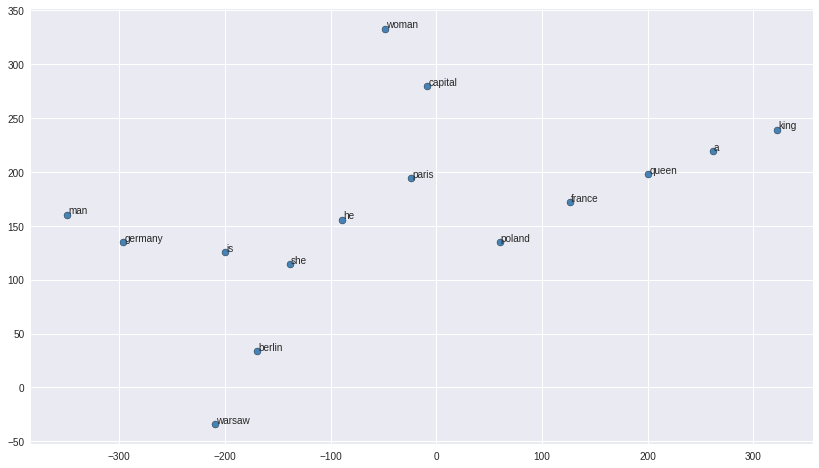

In [104]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
word_vectors = [W1[:,i].data.numpy() for i in range(len(word2idx.keys()))]
T = tsne.fit_transform(word_vectors)
labels = word2idx.keys()

plt.figure(figsize=(14,8))
plt.scatter(T[:,0], T[:,1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:,0], T[:,1]):
  plt.annotate(label, xy=(x+1, y+1), xytext=(0,0), textcoords='offset points')

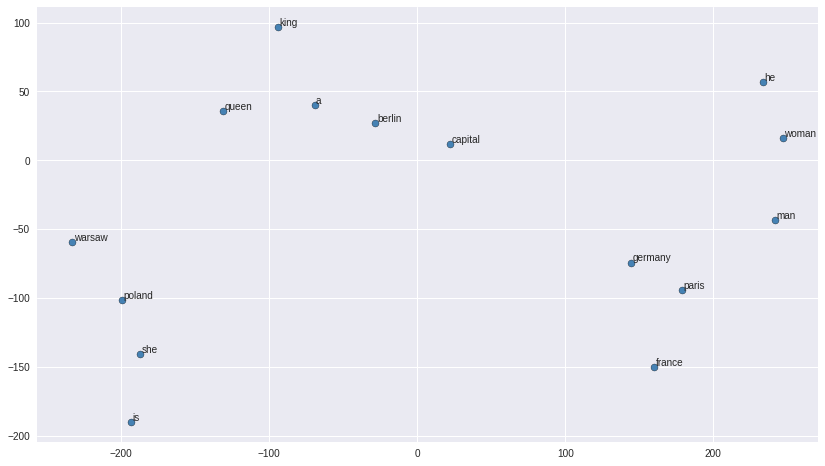

In [106]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline
tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=3)
np.set_printoptions(suppress=True)
word_vectors = [W2[i,:].data.numpy() for i in range(len(word2idx.keys()))]
T = tsne.fit_transform(word_vectors)
labels = word2idx.keys()

plt.figure(figsize=(14,8))
plt.scatter(T[:,0], T[:,1], c='steelblue', edgecolors='k')
for label, x, y in zip(labels, T[:,0], T[:,1]):
  plt.annotate(label, xy=(x+1, y+1), xytext=(0,0), textcoords='offset points')